In [2]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox

import warnings
warnings.filterwarnings("ignore")

In [111]:
df=pd.read_excel("Data/Temp/FULL_prepared_data_ampm_SUP_v11.xlsx")

In [75]:
import matplotlib.font_manager as font_manager
# Use Times New Roman font
font_path = 'C:\\Windows\\Fonts\\times.ttf'
font_prop = font_manager.FontProperties(fname=font_path)

sns.set(font=font_prop.get_name())

In [76]:
df_bike=df[df.Mode=='Bic']
df_ped=df[df.Mode=='Ped']

In [81]:
df_bike.fillna(0, inplace=True)
df_ped.fillna(0, inplace=True)

In [106]:
#Manually change df_bike and df_ped and then save file with appropriate names
from scipy.stats import pearsonr, linregress

def calculate_ci(r, n, confidence=0.95):
    stderr = 1.0 / (n ** 0.5)
    delta = stderr * abs(r) * ((1 - r**2)/(n - 2))**0.5
    lower_bound = r - delta
    upper_bound = r + delta
    return lower_bound, upper_bound
cols = ['TotPop_1mile', 'TotPopMale_1mile', 'TotPopFemale_1mile', 'TotPop_05mile', 'TotPopMale_05mile', 'TotPopFemale_05mile', 'TotPop_025mile', 'TotPopMale_025mile', 'TotPopFemale_025mile', 'Edu_Bachelor_more_1mile', 'Edu_Bachelor_more_05mile', 'Edu_Bachelor_more_025mile', 'Income_1mile', 'Income_05mile', 'Income_025mile', 'HHI_less_35_1mile', 'HHI_35_45_1mile', 'HHI_45_60_1mile', 'HHI_60_100_1mile', 'HHI_100_150_1mile', 'HHI_150_more_1mile','HHI_less_35_05mile', 'HHI_35_45_05mile', 'HHI_45_60_05mile', 'HHI_60_100_05mile', 'HHI_100_150_05mile', 'HHI_150_more_05mile','HHI_less_35_025mile', 'HHI_35_45_025mile', 'HHI_45_60_025mile', 'HHI_60_100_025mile', 'HHI_100_150_025mile', 'HHI_150_more_025mile','Male_5_14_1mile', 'Male_15_24_1mile', 'Male_25_34_1mile', 'Male_35_54_1mile', 'Male_55_64_1mile', 'Male_65_over_1mile', 'Male_5_14_05mile', 'Male_15_24_05mile', 'Male_25_34_05mile', 'Male_35_54_05mile', 'Male_55_64_05mile', 'Male_65_over_05mile', 'Male_5_14_025mile', 'Male_15_24_025mile', 'Male_25_34_025mile', 'Male_35_54_025mile', 'Male_55_64_025mile', 'Male_65_over_025mile',  'Female_5_14_1mile', 'Female_15_24_1mile', 'Female_25_34_1mile', 'Female_35_54_1mile', 'Female_55_64_1mile', 'Female_65_over_1mile', 'Female_5_14_05mile', 'Female_15_24_05mile', 'Female_25_34_05mile', 'Female_35_54_05mile', 'Female_55_64_05mile', 'Female_65_over_05mile', 'Female_5_14_025mile', 'Female_15_24_025mile', 'Female_25_34_025mile', 'Female_35_54_025mile', 'Female_55_64_025mile', 'Female_65_over_025mile', 'Pop_Race_White_1mile', 'Pop_Race_Black_1mile', 'Pop_Race_Asian_1mile', 'Pop_Race_Native_1mile', 'Pop_Race_Two_1mile', 'Pop_Race_White_05mile', 'Pop_Race_Black_05mile', 'Pop_Race_Asian_05mile', 'Pop_Race_Native_05mile', 'Pop_Race_Two_05mile', 'Pop_Race_White_025mile', 'Pop_Race_Black_025mile', 'Pop_Race_Asian_025mile', 'Pop_Race_Native_025mile', 'Pop_Race_Two_025mile', 'House_1mile', 'House_05mile', 'House_025mile','UI_025mile', 'UI_05mile', 'UI_1mile', 'UA_025mile', 'UA_05mile', 'UA_1mile', 'UC_025mile', 'UC_05mile', 'UC_1mile', 'UL_025mile', 'UL_05mile', 'UL_1mile',  'UI_025mile', 'UI_05mile', 'UI_1mile', 'UA_025mile', 'UA_05mile', 'UA_1mile', 'UC_025mile', 'UC_05mile', 'UC_1mile', 'UL_025mile', 'UL_05mile', 'UL_1mile',  'Bus_025', 'Tram_strcar_lrail_025', 'Bus_05', 'Tram_strcar_lrail_05', 'Bus_1', 'Tram_strcar_lrail_1', 'Intsct_05mile', 'Intsct_025mile', 'Intsct_1mile',  'ADT_025mile', 'ADT_05mile', 'ADT_1mile']

# Group columns based on their names
all_buff=[]
column_groups = {}
for col in cols:
    base_col_name = col.rsplit('_', 1)[0]
    if base_col_name not in column_groups:
        column_groups[base_col_name] = []
    column_groups[base_col_name].append(col)

# Standardize buffer size extraction
def extract_buffer_size(column):
    buffer_size = column.split('_')[-1].replace('mile', '').replace('miles', '')
    all_buff.append(buffer_size)
    if buffer_size == '1':
        return '1_mile'
    elif buffer_size == '05':
        return '05_mile'
    elif buffer_size == '025':
        return '025_mile'
    elif buffer_size == '05s':
        return '05_mile'
    elif buffer_size == '025s':
        return '025_mile'
    return None

# Calculate correlation with daily_count for each group
correlations = {}
for base_col_name, columns in column_groups.items():
    correlations[base_col_name] = {}
    for col in columns:
        buffer_size = extract_buffer_size(col)
        r, p = pearsonr(df_ped['daily_count'], df_ped[col]) ###############################MANUALLY change df_
        ci_lower, ci_upper = calculate_ci(r, len(df_ped))
        correlations[base_col_name][buffer_size] = f"{r:.3f} ({ci_lower:.3f}, {ci_upper:.3f})"
# Create the final table
final_table = pd.DataFrame(columns=['column_name', '1_mile', '05_mile', '025_mile', 'best_buffer_size'])
for col, buffer_correlations in correlations.items():
    data = {'column_name': col}
    best_buffer_size, highest_correlation = None, None

    for buffer_size, correlation in buffer_correlations.items():
        data[buffer_size] = correlation
        r = float(correlation.split()[0])
        r = abs(r) #We want to compare both + and - correlations
        if highest_correlation is None or r > highest_correlation:
            highest_correlation = r
            best_buffer_size = buffer_size
    data['best_buffer_size'] = best_buffer_size
    final_table = final_table.append(data, ignore_index=True)
final_table.best_buffer_size=final_table.best_buffer_size.replace({"025_mile":"0.25 miles", "05_mile":"0.5 miles", "1_mile":"1 mile"})

In [107]:
final_table.to_csv("Data/Temp/FULL_buffer_analysis_ped_usingv11.csv")

In [91]:
print(list(final_table.column_name))

['TotPop', 'TotPopMale', 'TotPopFemale', 'Edu_Bachelor_more', 'Income', 'HHI_less_35', 'HHI_35_45', 'HHI_45_60', 'HHI_60_100', 'HHI_100_150', 'HHI_150_more', 'Male_5_14', 'Male_15_24', 'Male_25_34', 'Male_35_54', 'Male_55_64', 'Male_65_over', 'Female_5_14', 'Female_15_24', 'Female_25_34', 'Female_35_54', 'Female_55_64', 'Female_65_over', 'Pop_Race_White', 'Pop_Race_Black', 'Pop_Race_Asian', 'Pop_Race_Native', 'Pop_Race_Two', 'House', 'UI', 'UA', 'UC', 'UL', 'Bus', 'Tram_strcar_lrail', 'Intsct', 'ADT']


#### Descriptive analysis table

In [3]:
df=pd.read_excel("Data/Temp/FULL_prepared_data_ampm_SUP_v11.xlsx")
results = []

# Loop over each column in the dataframe
for col in df.select_dtypes(include=['number']).columns:
    # Compute the maximum, minimum, mean, and standard deviation for the current column
    col_max = df[col].max()
    col_min = df[col].min()
    col_mean = df[col].mean()
    col_std = df[col].std()
    
    # Append the results to the list
    results.append((col, f"{col_min:.4f}/{col_max:.4f}", f"{col_mean:.4f} ({col_std:.4f})"))

# Create a new dataframe from the results list
results_df = pd.DataFrame(results, columns=['Attribute Name', 'Min/ Max', 'Mean (SD)'])


In [118]:
print(list(df.columns))

['stationid', 'year', 'Mode', 'ampeak', 'pmpeak', 'daily_count', 'county', 'Latitude', 'Longitude', 'TotPop_1mile', 'TotPopMale_1mile', 'TotPopFemale_1mile', 'Male_5_14_1mile', 'Male_15_24_1mile', 'Male_25_34_1mile', 'Male_35_54_1mile', 'Male_55_64_1mile', 'Male_65_over_1mile', 'Female_5_14_1mile', 'Female_15_24_1mile', 'Female_25_34_1mile', 'Female_35_54_1mile', 'Female_55_64_1mile', 'Female_65_over_1mile', 'Pop_Race_White_1mile', 'Pop_Race_Black_1mile', 'Pop_Race_Asian_1mile', 'Pop_Race_Native_1mile', 'Pop_Race_Two_1mile', 'House_1mile', 'House_Family_1mile', 'Edu_Bachelor_more_1mile', 'HHI_less_35_1mile', 'HHI_35_45_1mile', 'HHI_45_60_1mile', 'HHI_60_100_1mile', 'HHI_100_150_1mile', 'HHI_150_more_1mile', 'Income_1mile', 'TotPop_05mile', 'TotPopMale_05mile', 'TotPopFemale_05mile', 'Male_5_14_05mile', 'Male_15_24_05mile', 'Male_25_34_05mile', 'Male_35_54_05mile', 'Male_55_64_05mile', 'Male_65_over_05mile', 'Female_5_14_05mile', 'Female_15_24_05mile', 'Female_25_34_05mile', 'Female_35_

In [120]:
df.UI_05mile.max()

0.0014653714805151

In [116]:
results_df

,Attribute Name,Min/ Max,Mean (SD)
0,year,2015.00/2021.00,2018.29 (1.87)
1,ampeak,0.00/716.55,61.52 (90.91)
2,pmpeak,0.00/674.34,60.62 (90.38)
3,daily_count,0.86/4050.64,390.18 (561.53)
4,Latitude,25.91/33.92,31.77 (1.76)
...,...,...,...
180,ADT_05mile,nan/nan,nan (nan)
181,ADT_1mile,nan/nan,nan (nan)
182,ADT_previous_year_025mile,nan/nan,nan (nan)
183,ADT_previous_year_05mile,nan/nan,nan (nan)


In [5]:
results_df.to_csv("Data/Temp/descriptive_information_raw_usingv11_4digit.csv")

### checking for all

In [72]:
st=list(ori_df[(ori_df.county=="Travis")&(ori_df.Mode=="All")].stationid)
travis_all_st=ori_df[ori_df.stationid.isin(st)]

In [70]:
travis_all_st.to_csv("Data/Temp/Travis_county_data_fromv11dataset.csv")

,stationid,year,Mode,ampeak,pmpeak,daily_count,county,Latitude,Longitude,TotPop_1mile,...,TAVG,TMAX,TMIN,AWND,ADT_025mile,ADT_05mile,ADT_1mile,ADT_previous_year_025mile,ADT_previous_year_05mile,ADT_previous_year_1mile
98,AU0025,2017,All,5.272727,3.000000,28.090909,Travis,30.232080,-97.816872,8761.97324,...,69.946875,80.971875,58.910938,4.695556,NaN,NaN,NaN,NaN,NaN,NaN
99,AU0027,2017,All,2.916667,1.166667,14.833333,Travis,30.241945,-97.812775,4843.96345,...,69.946875,80.971875,58.910938,4.695556,NaN,NaN,NaN,NaN,NaN,NaN
100,AU0028,2017,All,110.272727,204.363636,1166.818182,Travis,30.244236,-97.810280,5255.64562,...,69.946875,80.971875,58.910938,4.695556,NaN,NaN,NaN,NaN,NaN,NaN
101,AU0030,2017,All,10.636364,7.000000,61.000000,Travis,30.267790,-97.777779,30722.93178,...,72.100000,82.900000,61.300000,4.900000,NaN,NaN,NaN,NaN,NaN,NaN
102,AU0031,2017,All,39.000000,19.636364,170.272727,Travis,30.269983,-97.774780,32410.18199,...,72.100000,82.900000,61.300000,4.900000,NaN,NaN,NaN,NaN,NaN,NaN
103,AU0033,2017,All,148.700000,103.100000,852.700000,Travis,30.251392,-97.735558,89875.28685,...,67.000000,79.400000,54.600000,4.695556,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
counts = ori_df.groupby('stationid')['Mode'].nunique()
counts.value_counts()

1    97
2    83
Name: Mode, dtype: int64

#### ..

In [73]:
url="C:/Users/P-Koirala/OneDrive - Texas A&M Transportation Institute/Desktop/Data/SUP/#RAW/Data/BPCX data from Phil/"
stationinfo=pd.read_csv(url+"_SELECT_s_station_id_tmg_s_flowid_txdot_s_eco_id_s_eco_name_s_se Readable as of 202212211543.csv")

In [78]:
stationinfo.head()

,station_id_tmg,flowid_txdot,eco_id,eco_name,serial_number,owner,station_name,year_station_established,year_station_discontinued,latitude,...,street_lighting,transit,shade,nonmotorized_facility_buffer_width,provider_name,requester_name,surface_type,vendor,primary_count_purpose,count_interval
0,AL0001,AL0001-EB-Bic,104012620,Cottonwood Trail north of Exchange Pkwy,YUG14025161,North Central Texas Council of Governments,Cottonwood Trail north of Exchange Pkwy,2016,NaN,33.119987,...,None,No,None,No buffer,NaN,NaN,Concrete,Eco-Counter,Planning or reporting,15.0
1,AL0001,AL0001-EB-Ped,102012620,Cottonwood Trail north of Exchange Pkwy,YUG14025161,North Central Texas Council of Governments,Cottonwood Trail north of Exchange Pkwy,2016,NaN,33.119987,...,None,No,None,No buffer,NaN,NaN,Concrete,Eco-Counter,Planning or reporting,15.0
2,AL0001,AL0001-WB-Bic,103012620,Cottonwood Trail north of Exchange Pkwy,YUG14025161,North Central Texas Council of Governments,Cottonwood Trail north of Exchange Pkwy,2016,NaN,33.119987,...,None,No,None,No buffer,NaN,NaN,Concrete,Eco-Counter,Planning or reporting,15.0
3,AL0001,AL0001-WB-Ped,101012620,Cottonwood Trail north of Exchange Pkwy,YUG14025161,North Central Texas Council of Governments,Cottonwood Trail north of Exchange Pkwy,2016,NaN,33.119987,...,None,No,None,No buffer,NaN,NaN,Concrete,Eco-Counter,Planning or reporting,15.0
4,AL0002,AL0002-NB-Bic,104012621,Watters Trail south of Boon Elem School,YUG14025162,North Central Texas Council of Governments,Watters Trail south of Boon Elem School,2016,NaN,33.110989,...,None,No,Partial,No buffer,NaN,NaN,Concrete,Eco-Counter,Planning or reporting,15.0


#### Checking 

In [11]:
ori_df=pd.read_excel("Data/Temp/FULL_prepared_data_ampm_v11.xlsx")

In [28]:
df=pd.read_csv("Data/BPCX data from Phil/ADT_Counts_202304261556.csv")
dfA=pd.read_csv("Data/BPCX data from Phil/AADT_202304261555.csv")

In [31]:
df['stationid'] = df['flowid_txdot'].str.split('-').str[0]
dfA['stationid'] = dfA['flowid_txdot'].str.split('-').str[0]

1

In [25]:
ori_df[ori_df.stationid=='LC0012']

,stationid,year,Mode,ampeak,pmpeak,daily_count,county,Latitude,Longitude,TotPop_1mile,...,TAVG,TMAX,TMIN,AWND,ADT_025mile,ADT_05mile,ADT_1mile,ADT_previous_year_025mile,ADT_previous_year_05mile,ADT_previous_year_1mile
729,LC0012,2017,All,7.25,8.916667,54.083333,Galveston,29.478252,-95.148331,4208.80417,...,72.1,80.6,63.6,8.393175,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df[df.stationid=='LC0012']

,flowid_txdot,count_int,year,count_method_code,ADT,ADT_Rounded,Num_Days_per_Count,Num_Hrs_per_Count,Num_Intrvls_per_Count,cmpl1_incmpl0,stationid
787,LC0012-All-All,15,2017,2,54.083333,55.0,12,288,1152,1,LC0012


2

In [27]:
ori_df[ori_df.stationid=='HO0043']

,stationid,year,Mode,ampeak,pmpeak,daily_count,county,Latitude,Longitude,TotPop_1mile,...,TAVG,TMAX,TMIN,AWND,ADT_025mile,ADT_05mile,ADT_1mile,ADT_previous_year_025mile,ADT_previous_year_05mile,ADT_previous_year_1mile
705,HO0043,2017,All,83.875,77.6875,737.625,Harris,29.783276,-95.413887,67492.30692,...,72.5,81.1,63.92,8.54,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df[df.stationid=='HO0043']

,flowid_txdot,count_int,year,count_method_code,ADT,ADT_Rounded,Num_Days_per_Count,Num_Hrs_per_Count,Num_Intrvls_per_Count,cmpl1_incmpl0,stationid
753,HO0043-All-All,15,2017,2,737.625,738.0,16,384,1536,1,HO0043


3

In [29]:
ori_df[ori_df.stationid=='HG0002']

,stationid,year,Mode,ampeak,pmpeak,daily_count,county,Latitude,Longitude,TotPop_1mile,...,TAVG,TMAX,TMIN,AWND,ADT_025mile,ADT_05mile,ADT_1mile,ADT_previous_year_025mile,ADT_previous_year_05mile,ADT_previous_year_1mile
636,HG0002,2021,Bic,3.896552,5.862069,20.586207,Cameron,26.172297,-97.696984,32196.18954,...,75.9,85.4,66.5,8.393175,NaN,NaN,NaN,NaN,NaN,NaN
637,HG0002,2021,Ped,16.850575,16.758621,84.977011,Cameron,26.172297,-97.696984,32196.18954,...,75.9,85.4,66.5,8.393175,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df[df.stationid=='HG0002']

,flowid_txdot,count_int,year,count_method_code,ADT,ADT_Rounded,Num_Days_per_Count,Num_Hrs_per_Count,Num_Intrvls_per_Count,cmpl1_incmpl0,stationid


In [33]:
dfA[dfA.stationid=='HG0002']

,flowid_txdot,count_int,year,AADT,AADT_Rounded,Num_Intrvls_per_YY,Cal_Days_per_Year,Num_Hours_per_YY,Sum_Num_DOWs,Num_Months,cmpl1_incmpl0,stationid
1207,HG0002-EB-Bic,15,2021,9.872644,10,8352,92,504,21,3,0,HG0002
1208,HG0002-EB-Ped,15,2021,48.495652,49,8352,92,504,21,3,0,HG0002
1209,HG0002-WB-Bic,15,2021,10.906702,11,8352,92,504,21,3,0,HG0002
1210,HG0002-WB-Ped,15,2021,36.543840,37,8352,92,504,21,3,0,HG0002
1392,HG0002-EB-Bic,15,2022,16.650456,17,33982,365,2016,84,12,1,HG0002
1393,HG0002-EB-Ped,15,2022,51.595433,52,33982,365,2016,84,12,1,HG0002
1394,HG0002-WB-Bic,15,2022,12.696072,13,33982,365,2016,84,12,1,HG0002
1395,HG0002-WB-Ped,15,2022,38.964064,39,33982,365,2016,84,12,1,HG0002


Old method

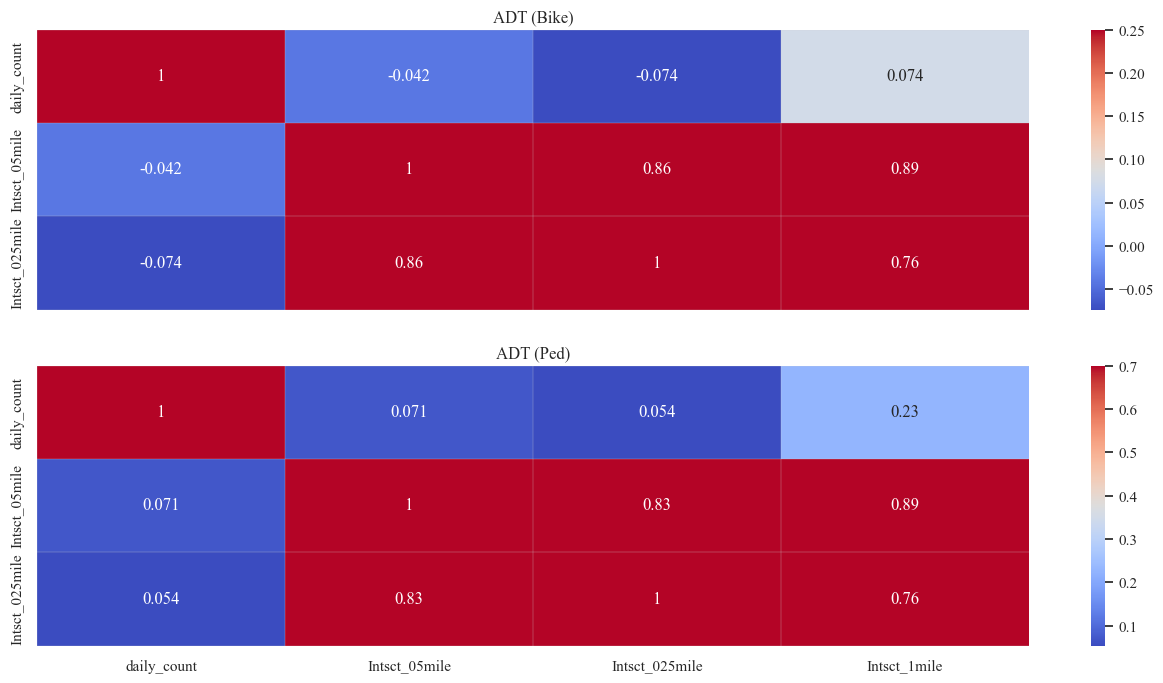

In [17]:
demo_pop_cols=['daily_count','TotPop_1mile','TotPopMale_1mile','TotPopFemale_1mile','TotPop_05miles','TotPopMale_05miles','TotPopFemale_05miles','TotPop_025miles','TotPopMale_025miles','TotPopFemale_025miles']
demo_edu_cols=['daily_count','Edu_Bachelor_more_1mile','Edu_Bachelor_more_05miles','Edu_Bachelor_more_025miles']
demo_inc_cols=['daily_count','Income_1mile','Income_05miles','Income_025miles']
demo_HHinc_cols=['HHI_less_35_1mile', 'HHI_35_45_1mile', 'HHI_45_60_1mile', 'HHI_60_100_1mile', 'HHI_100_150_1mile', 'HHI_150_more_1mile']
demo_Mage_cols=['daily_count','Male_5_14_1mile', 'Male_15_24_1mile', 'Male_25_34_1mile', 'Male_35_54_1mile', 'Male_55_64_1mile', 'Male_65_over_1mile','Male_5_14_05miles', 'Male_15_24_05miles', 'Male_25_34_05miles', 'Male_35_54_05miles', 'Male_55_64_05miles', 'Male_65_over_05miles','Male_5_14_025miles', 'Male_15_24_025miles', 'Male_25_34_025miles', 'Male_35_54_025miles', 'Male_55_64_025miles', 'Male_65_over_025miles']
demo_Fage_cols=['daily_count','Female_5_14_1mile', 'Female_15_24_1mile', 'Female_25_34_1mile', 'Female_35_54_1mile', 'Female_55_64_1mile', 'Female_65_over_1mile','Female_5_14_05miles', 'Female_15_24_05miles', 'Female_25_34_05miles', 'Female_35_54_05miles', 'Female_55_64_05miles', 'Female_65_over_05miles','Female_5_14_025miles', 'Female_15_24_025miles', 'Female_25_34_025miles', 'Female_35_54_025miles', 'Female_55_64_025miles', 'Female_65_over_025miles' ]
demo_other_cols=['daily_count','Pop_Race_White_1mile', 'Pop_Race_Black_1mile','Pop_Race_Asian_1mile','Pop_Race_Native_1mile', 'Pop_Race_Two_1mile','Pop_Race_White_05miles', 'Pop_Race_Black_05miles','Pop_Race_Asian_05miles','Pop_Race_Native_05miles', 'Pop_Race_Two_05miles','Pop_Race_White_025miles', 'Pop_Race_Black_025miles','Pop_Race_Asian_025miles','Pop_Race_Native_025miles', 'Pop_Race_Two_025miles',
                 'House_1mile','House_05miles','House_025miles']
road_den_cols=['daily_count','UI_025mile', 'UI_05mile', 'UI_1mile', 'UA_025mile', 'UA_05mile', 'UA_1mile', 'UC_025mile', 'UC_05mile', 'UC_1mile', 'UL_025mile', 'UL_05mile', 'UL_1mile']
road_transit_cols=['daily_count','Bus_025', 'Tram_strcar_lrail_025', 'Bus_05', 'Tram_strcar_lrail_05', 'Bus_1', 'Tram_strcar_lrail_1']
ints=['daily_count','Intsct_05mile', 'Intsct_025mile', 'Intsct_1mile']
adt=['daily_count','ADT_025mile', 'ADT_05mile', 'ADT_1mile']
A=df_bike[ints].corr(method="pearson")
A1=df_ped[ints].corr(method="pearson")
fig, ax=plt.subplots(2,1,figsize=(16,8))
ax0=sns.heatmap(A[0:3],ax=ax[0], annot=True, cmap='coolwarm', vmax=0.25) #using coolwarm only when coeff +ve and -ve
ax[0].set_title("ADT (Bike)")
 
ax1=sns.heatmap(A1[0:3],ax=ax[1], annot=True, cmap='coolwarm', vmax=0.7) 
ax[1].set_title("ADT (Ped)")
ax[0].set_xticklabels([])
for i in range(len(A)):
    ax0.axhline(y=i, color='lightgrey', linewidth=0.2)
    ax0.axvline(x=i, color='lightgrey', linewidth=0.2)
for i in range(len(A1)):
    ax1.axhline(y=i, color='lightgrey', linewidth=0.2)
    ax1.axvline(x=i, color='lightgrey', linewidth=0.2)


### Time series Graphs

In [7]:
from sklearn.ensemble import RandomForestRegressor
def FeaImp(df):
    X = df.drop("count", axis=1)
    y = df["count"]
    model = RandomForestRegressor(random_state=0)
    model.fit(X, y)
    importances = model.feature_importances_
    features = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    features = features.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=features[0:10])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.title('Feature Importance Plot')

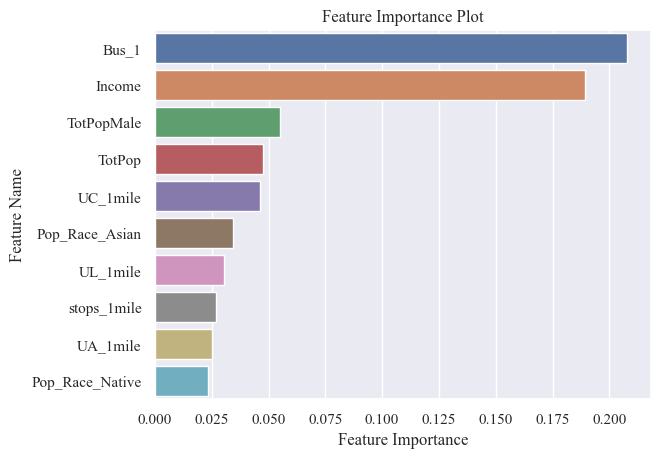

In [430]:
FeaImp(df_bike_)

In [392]:
len(m.stationid.unique())

57

In [433]:
b=df_ped.groupby(["stationid", "year"], as_index=False).agg({'count': 'sum'})

m = pd.merge(b, df_ped, on=['stationid', 'year'])
m=m[(m.hour==0) & (m.direction)] #Here the merge adds the total count (count for each station for each year) to the dataset so we just need one hour
m.drop(["hour", "count_y", "direction","flowid_txdot"],axis=1, inplace=True)
m=m.rename(columns={"count_x":"count"})                #Since hour and hourcount and direction and flow_txdot is not needed now we delete them
m=m.drop_duplicates() #since there will be two or three of the same row with different direction. But the direction is already added while we groupbyed so deleting dublicates in abscense of direction column.
df_ped_=m.reset_index(drop=True)
#For model training
df_ped_.drop(["stationid", "Mode",'remark', 'remark_2'], axis=1,inplace=True) 
df_ped_.year=df_ped_.year.astype(int)
df_ped_=df_ped_.fillna(0)

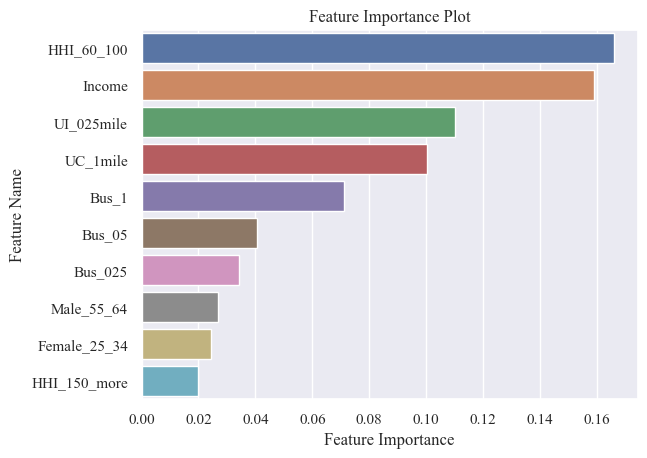

In [434]:
FeaImp(df_ped_)